In [43]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
import json
import sys
from datetime import datetime

from keras.models import Sequential
from keras import layers, utils, callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

%matplotlib inline

### Search for dataset dirs
Define data structures and directories

In [2]:
base_data_dir = os.path.join('.', 'data', 'termoplast')
aug_data_dir = os.path.join('.', 'data', 'augmented_termoplast')
# base_data_dir = os.path.join('.', 'data', 'img_demo')
# aug_data_dir = os.path.join('.', 'data', 'augmented_img_demo')
training_path = os.path.join(aug_data_dir, 'training')
testing_path = os.path.join(aug_data_dir, 'testing')
labels = [{'name': d.lower(), 
           'original_path': os.path.join(base_data_dir, d.lower()), 
           'training_path': os.path.join(training_path, d.lower()), 
           'testing_path':  os.path.join(testing_path, d.lower())
          } for d in os.listdir(base_data_dir)]
tot_labels = len(labels)
print(tot_labels)
for i, label in enumerate(labels):
    label['int_rep'] = i
    print(label)

6
{'name': 'bruciatura', 'original_path': '.\\data\\termoplast\\bruciatura', 'training_path': '.\\data\\augmented_termoplast\\training\\bruciatura', 'testing_path': '.\\data\\augmented_termoplast\\testing\\bruciatura', 'int_rep': 0}
{'name': 'foro', 'original_path': '.\\data\\termoplast\\foro', 'training_path': '.\\data\\augmented_termoplast\\training\\foro', 'testing_path': '.\\data\\augmented_termoplast\\testing\\foro', 'int_rep': 1}
{'name': 'gelo', 'original_path': '.\\data\\termoplast\\gelo', 'training_path': '.\\data\\augmented_termoplast\\training\\gelo', 'testing_path': '.\\data\\augmented_termoplast\\testing\\gelo', 'int_rep': 2}
{'name': 'marca rullo', 'original_path': '.\\data\\termoplast\\marca rullo', 'training_path': '.\\data\\augmented_termoplast\\training\\marca rullo', 'testing_path': '.\\data\\augmented_termoplast\\testing\\marca rullo', 'int_rep': 3}
{'name': 'piega', 'original_path': '.\\data\\termoplast\\piega', 'training_path': '.\\data\\augmented_termoplast\\trai

### Function to create augmented images + binarization

In [9]:
ROTATE_RATIO = 1.4
SCALE_RATIO = 1.1 # deactivated for now
REF_HOR_RATIO = 1.4
NUMBER_OF_INC_THREASHOLD = 3
TRAINING_RATIO = .8

In [4]:
def get_mean_background(image) -> int:
    mean1 = cv.meanStdDev(image[:20, :20, 0])
    mean2 = cv.meanStdDev(image[:-20, :20, 0])
    mean3 = cv.meanStdDev(image[:20, :-20, 0])
    mean4 = cv.meanStdDev(image[:-20, :-20, 0])
    return int((mean1[0][0][0] + mean2[0][0][0] + mean3[0][0][0] +mean4[0][0][0]) / 4)

In [5]:
def rotate_90_l(image):
    rows, cols, _ = image.shape
    M = cv.getRotationMatrix2D((cols/2,rows/2),90,1)
    dst = cv.warpAffine(image, M, (cols,rows))
    return dst

In [6]:
def ref_hor(image):
    rows, cols, _ = image.shape
    M = np.float32([[0,1,0],[1,0,0]])
    dst = cv.warpAffine(image, M, (cols,rows))
    return dst

In [7]:
def random_resize(image):
    scale = np.random.randint(1, 4)
    if np.random.random_sample() >= 0.5:
        scale = 1 / scale
    return cv.resize(image,None,fx=scale, fy=scale, interpolation = cv.INTER_CUBIC)

In [39]:
def _imshow(image):
    plt.imshow(image, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([]) 
    plt.show()

In [10]:

def generate_augmented_for_label(label_info: dict, gen_binary=False):
    if (not os.path.exists(label_info['training_path'])):
        os.makedirs(label_info['training_path'])
    if (not os.path.exists(label_info['testing_path'])):
        os.makedirs(label_info['testing_path'])
    files = list(filter(lambda f: '.jpg' in f, os.listdir(label_info['original_path'])))
    for i, file_name in enumerate(files):
        # print("{} / {}".format(i + 1, len(files)))
        f_name = file_name.replace('.jpg', '')
        image = cv.imread(os.path.join(label_info['original_path'], file_name))
        # _imshow(image)
        mean = get_mean_background(image)
        increments = np.linspace(0, 20, NUMBER_OF_INC_THREASHOLD, endpoint=False)
        # binarization
        for inc in increments:
            if np.random.random_sample() < TRAINING_RATIO:
                path = label_info['training_path']
            else:
                path = label_info['testing_path']
            if gen_binary:
                t = int(mean - inc)
                _, binary = cv.threshold(image, t, 255, cv.THRESH_BINARY_INV)
                cv.imwrite(os.path.join(path, f_name + '_' + str(t) + '_binary' + '.jpg'), binary)
            else:
                t = inc
                binary = np.clip(image + inc, 0, 255)
                cv.imwrite(os.path.join(path, f_name + '_' + str(t) + '_lum' + '.jpg'), binary)
            # _imshow(binary)
            
            if np.random.random_sample() >= ROTATE_RATIO:
                rotated = binary
                for r in range(np.random.randint(1, 3)):
                    rotated = rotate_90_l(rotated)
                cv.imwrite(os.path.join(path, f_name + '_' + str(t) + '_rotated' + '.jpg'), rotated)
               
            if np.random.random_sample() >= SCALE_RATIO:
                scaled = random_resize(binary)
                cv.imwrite(os.path.join(path, f_name + '_' + str(t) + '_scaled' + '.jpg'), scaled)
            
            if np.random.random_sample() >= REF_HOR_RATIO:
                reflected = ref_hor(binary)
                cv.imwrite(os.path.join(path, f_name + '_' + str(t) + '_ref_hor' + '.jpg'), reflected)
            


### Generate augmented images

In [12]:
for label_info in labels:
    print("Started ", label_info["name"])
    generate_augmented_for_label(label_info)
print("END")
#generate_augmented_for_label(labels[-1])

Started  bruciatura
Started  foro
Started  gelo
Started  marca rullo
Started  piega
Started  sporco
END


### Define model

In [68]:
model = Sequential()
output = 3
# model structure
model.add(layers.Conv2D(output, kernel_size=3, strides=(2, 2), activation='relu', padding='valid', input_shape=(180, 212, 1)))
model.add(layers.MaxPooling2D(pool_size=(5, 5), strides=(1, 1)))
output = output + 3
model.add(layers.Conv2D(output, kernel_size=3, strides=(2, 2), activation='relu', padding='valid'))
model.add(layers.MaxPooling2D(pool_size=(5, 5), strides=(1, 1)))
output = output + 3
model.add(layers.Conv2D(output, kernel_size=3, strides=(2, 2), activation='relu', padding='valid'))
model.add(layers.MaxPooling2D(pool_size=(5, 5), strides=(1, 1)))
output = output + 3
model.add(layers.Conv2D(output, kernel_size=3, strides=(2, 2), activation='relu', padding='valid'))
model.add(layers.MaxPooling2D(pool_size=(5, 5), strides=(1, 1)))
# reshape and fully connected
# model.add(layers.Flatten()) flatten is not usable cause it's not compatible with opencv inference
a, b, c, d = model.output_shape
a = b * c * d
model.add(layers.Permute([1, 2, 3]))  # Indicate NHWC data layout
model.add(layers.Reshape((a,)))
model.add(layers.Dense(tot_labels, activation='softmax'))

# print stuff
utils.print_summary(model)
utils.plot_model(model, to_file='model.png')

# compiling
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 89, 105, 3)        30        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 85, 101, 3)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 42, 50, 6)         168       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 38, 46, 6)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 18, 22, 9)         495       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 18, 9)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 6, 8, 12)          984       
__________

In [71]:
train_datagen = ImageDataGenerator(
        shear_range=0.4,
        zoom_range=0.2,
        vertical_flip=True,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        training_path,
        target_size=(180, 212),
        # save_to_dir=os.path.join(aug_data_dir, 'generated_demo', 'training'),
        # save_format='jpeg',
        color_mode='grayscale',
        batch_size=32,
        class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(
        testing_path,
        target_size=(180, 212),
        # save_to_dir=os.path.join(aug_data_dir, 'generated_demo', 'testing'),
        # save_format='jpeg',
        color_mode='grayscale',
        batch_size=32,
        class_mode='categorical')

# callbacks
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
# tb = callbacks.TensorBoard(log_dir='linescan-model/logs', histogram_freq=4, batch_size=32, write_graph=True, write_grads=False, write_images=True)

history = model.fit_generator(
        train_generator,
        # steps_per_epoch=10,
        # epochs=1,
        steps_per_epoch=1000,
        epochs=15,
        validation_data=validation_generator,
        validation_steps=300,
        callbacks=[es] #, tb]
)

Found 1150 images belonging to 6 classes.
Found 269 images belonging to 6 classes.
Epoch 1/15
1000/1000 [==============================] - 151s 151ms/step - loss: 1.0788 - categorical_accuracy: 0.5510 - val_loss: 0.8303 - val_categorical_accuracy: 0.6134
Epoch 2/15
1000/1000 [==============================] - 151s 151ms/step - loss: 0.7522 - categorical_accuracy: 0.7022 - val_loss: 0.5818 - val_categorical_accuracy: 0.8030
Epoch 3/15
1000/1000 [==============================] - 151s 151ms/step - loss: 0.5998 - categorical_accuracy: 0.7747 - val_loss: 0.4562 - val_categorical_accuracy: 0.8030
Epoch 4/15
1000/1000 [==============================] - 151s 151ms/step - loss: 0.4883 - categorical_accuracy: 0.8254 - val_loss: 0.4050 - val_categorical_accuracy: 0.8327
Epoch 5/15
1000/1000 [==============================] - 151s 151ms/step - loss: 0.4250 - categorical_accuracy: 0.8468 - val_loss: 0.3671 - val_categorical_accuracy: 0.8513
Epoch 6/15
1000/1000 [==============================] - 1

In [57]:
now = datetime.now()
date_time = now.strftime("%Y%m%d-%H%M%S")
model_file_name = 'acc_{0:.2f}_'.format(history.history['val_categorical_accuracy'][-1]) + date_time + '.h5'
model.save(os.path.join('linescan-model', model_file_name))

-------------  dif00027.jpg  -------------


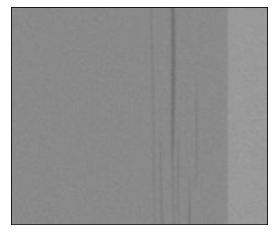

>>  sporco
-------------------------------------------
-------------  dif00028.jpg  -------------


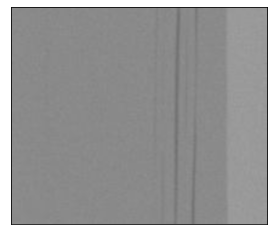

>>  sporco
-------------------------------------------
-------------  dif00084.jpg  -------------


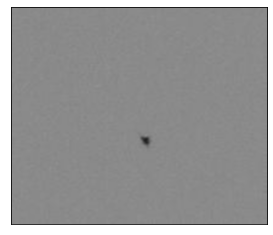

>>  marca rullo
-------------------------------------------
-------------  dif00147.jpg  -------------


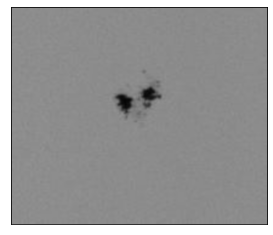

>>  sporco
-------------------------------------------
-------------  dif00179.jpg  -------------


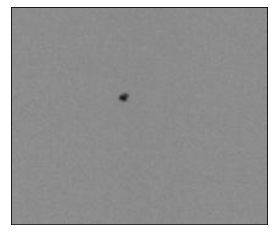

>>  sporco
-------------------------------------------


In [69]:
test_dir = os.path.join('.', 'data', 'test')
for file_name in os.listdir(test_dir):
    if '.jpg' in file_name or '.jpeg' in file_name:
        print("------------- ", file_name, " -------------")
        test_image = cv.imread(os.path.join(test_dir, file_name))
        _imshow(test_image)
        test_image = cv.cvtColor(test_image, cv.COLOR_BGR2GRAY).reshape(180, 212, 1)
        p_id = model.predict(np.array([test_image])).argmax()
        for k in validation_generator.class_indices:
            if validation_generator.class_indices[k] == p_id:
                print(">> ", k)
        print("-------------------------------------------")

Utility to convert h5 version to a pd (tensorflow) freezed graph, needed for opencv

In [52]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

Use the previous function to convert model

In [59]:
frozen_graph = freeze_session(K.get_session(),  output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, "linescan-model", model_file_name.replace('h5', 'pb'), as_text=False)
tf.train.write_graph(frozen_graph, "linescan-model", model_file_name.replace('h5', 'pbtxt'), as_text=True)

INFO:tensorflow:Froze 90 variables.
INFO:tensorflow:Converted 90 variables to const ops.


'linescan-model\\acc_0.94_20190725-123732.pbtxt'

In [60]:
validation_generator.class_indices

{'bruciatura': 0,
 'foro': 1,
 'gelo': 2,
 'marca rullo': 3,
 'piega': 4,
 'sporco': 5}